#Topic: Detection of fraudulation in handwritten document by Transfer Learning






##Google Drive

In [ ]:
# To access google drive from colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#To Revoke access from google drive
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
# GPU Used:
!nvidia-smi

Sat Apr 23 05:34:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
# Importing functions from layers library
from keras.layers import Dense, Flatten

# Import Models from tensorflow
from keras.models import Model
from keras.models import load_model

# Importing InceptionV3 model for Transfer learning
from keras.applications import densenet, mobilenet, resnet

# Importing libraries for data pre=processing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img

# Importing Utility libraries
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt

##Data Pre-processing

In [ ]:
# re-size all the images to maintain consistency
train_dir = '/content/drive/MyDrive/Forgery-identification/Dataset/training-set'
test_dir = '/content/drive/MyDrive/Forgery-identification/Dataset/testing-set'
val_dir = '/content/drive/MyDrive/Forgery-identification/Dataset/validation-set'

Authentic Writer:


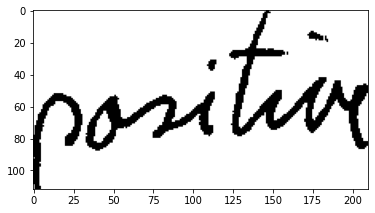

In [ ]:
img = image.load_img('/content/drive/MyDrive/Forgery-identification/Dataset/training-set/Authentic/b11_1.png')
print('Authentic Writer:')
plt.imshow(img)

In [ ]:
cv2.imread('/content/drive/MyDrive/Forgery-identification/Dataset/training-set/Authentic/b11_1.png').shape

(112, 210, 3)

Forged Writer:


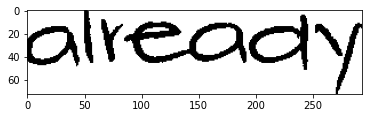

In [ ]:
img = image.load_img('/content/drive/MyDrive/Forgery-identification/Dataset/training-set/Forged/b12_1.png')
print('Forged Writer:')
plt.imshow(img)

In [ ]:
cv2.imread('/content/drive/MyDrive/Forgery-identification/Dataset/training-set/Forged/b10_1.png').shape

(54, 256, 3)

In [ ]:
folders = glob('/content/drive/MyDrive/Forgery-identification/Dataset/training-set/*')
print('No. of output classes are:',len(folders))

No. of output classes are: 2


In [ ]:
Image_size = [300, 500]
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Importing images from Training Dataset
Train_set = train_datagen.flow_from_directory( train_dir,
                                                 target_size = (300, 500),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 shuffle = True
                                                 )

Found 300 images belonging to 2 classes.


In [ ]:
# Importing images from Validation Dataset
Validation_set = datagen.flow_from_directory( val_dir,
                                            target_size = (300, 500),
                                            batch_size = 10,
                                            class_mode = 'categorical',
                                            shuffle = True
                                            )

Found 100 images belonging to 2 classes.


In [ ]:
# Importing images from Test Dataset
Test_set = datagen.flow_from_directory( test_dir,
                                            target_size = (300, 500),
                                            batch_size = 10,
                                            class_mode = 'categorical',
                                            shuffle = True
                                            )

Found 100 images belonging to 2 classes.


In [ ]:
# To Check Output Classes
output_classes = Train_set.class_indices
output_classes

{'Authentic': 0, 'Forged': 1}

##Implementing MobileNet model using Transfer Learning

In [ ]:
# Import the MobileNet library as shown below and add preprocessing layer to the front of the model
# Here we will be using imagenet weights

mobile = mobilenet.MobileNet(input_shape = Image_size + [3], weights= 'imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# We are training our model in imagenet weights so we don't use pre-existing weights
for layer in mobile.layers:
    layer.trainable = False

In [ ]:
# Flatten is used to flatten the input data processed through the model to match the dimension of the output layer
mob = Flatten()(mobile.output)

In [ ]:
# Dense is used to create a output layer fully connected to the hidden layers of the CNN model
mobile_pred = Dense(len(folders), activation='softmax')(mob)

# Finalizing the model with input and output.
mobile_model = Model(inputs = mobile.input, outputs = mobile_pred)

# The Structure of the model
mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 250, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 150, 250, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 150, 250, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 150, 250, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 150, 250, 32)     128       
 ation)                                                      

In [ ]:
# Since the data has a categorical class mode with use Categorical_crossentropy for loss function
# Adam for optimizer as it is recommended for by keras to get the best performance
mobile_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Fitting our Model.
mobile_fit = mobile_model.fit(
  Train_set,
  validation_data = Validation_set,
  epochs= 30, #100-1000
  steps_per_epoch = len(Train_set),
  validation_steps = len(Validation_set)
)

Epoch 1/30
30/30 [==============================] - 97s 3s/step - loss: 13.1945 - accuracy: 0.5100 - val_loss: 9.6942 - val_accuracy: 0.5100
Epoch 2/30
30/30 [==============================] - 10s 319ms/step - loss: 7.3686 - accuracy: 0.6533 - val_loss: 9.7263 - val_accuracy: 0.5600
Epoch 3/30
30/30 [==============================] - 10s 319ms/step - loss: 4.2318 - accuracy: 0.7800 - val_loss: 8.7794 - val_accuracy: 0.5800
Epoch 4/30
30/30 [==============================] - 10s 337ms/step - loss: 2.6240 - accuracy: 0.8300 - val_loss: 10.0576 - val_accuracy: 0.6000
Epoch 5/30
30/30 [==============================] - 10s 320ms/step - loss: 1.9250 - accuracy: 0.8533 - val_loss: 8.2533 - val_accuracy: 0.6600
Epoch 6/30
30/30 [==============================] - 10s 319ms/step - loss: 1.6429 - accuracy: 0.8867 - val_loss: 9.2920 - val_accuracy: 0.6200
Epoch 7/30
30/30 [==============================] - 10s 319ms/step - loss: 1.1211 - accuracy: 0.8867 - val_loss: 11.1179 - val_accuracy: 0.6400

In [ ]:
loss1, accuracy1 = mobile_model.evaluate(Test_set)

print("Loss on Test Dataset: ", loss1)
print("Accuracy on Test Dataset: ", accuracy1)

10/10 [==============================] - 31s 3s/step - loss: 15.6617 - accuracy: 0.6800
Loss on Test Dataset:  15.661738395690918
Accuracy on Test Dataset:  0.6800000071525574


In [ ]:
tr_loss1, tr_accuracy1 = mobile_model.evaluate(Train_set)

print("Loss on Train Dataset: ", tr_loss1)
print("Accuracy on Train Dataset: ", tr_accuracy1)

30/30 [==============================] - 9s 305ms/step - loss: 0.2129 - accuracy: 0.9800
Loss on Train Dataset:  0.21285583078861237
Accuracy on Train Dataset:  0.9800000190734863


In [ ]:
mobile_model.save('/content/drive/MyDrive/Forgery-identification/Models/MobileNet.h5')

##Implementing ResNet152 using Transfer Learning

In [ ]:
resnet152 = resnet.ResNet152(input_shape= Image_size + [3], weights= 'imagenet', include_top= False)

In [ ]:
for layer in resnet152.layers:
    layer.trainable = False

In [ ]:
res = Flatten()(resnet152.output)

In [ ]:
resnet_pred = Dense(len(folders), activation='softmax')(res)

resnet_model = Model(inputs = resnet152.input, outputs = resnet_pred)

resnet_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 506, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 250, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
resnet_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
resnet_fit = resnet_model.fit(
  Train_set,
  validation_data = Validation_set,
  epochs= 30,
  steps_per_epoch = len(Train_set),
  validation_steps = len(Validation_set)
)

Epoch 1/30
30/30 [==============================] - 25s 558ms/step - loss: 25.1031 - accuracy: 0.5100 - val_loss: 12.2554 - val_accuracy: 0.5200
Epoch 2/30
30/30 [==============================] - 15s 484ms/step - loss: 8.5790 - accuracy: 0.5967 - val_loss: 7.6847 - val_accuracy: 0.5700
Epoch 3/30
30/30 [==============================] - 14s 479ms/step - loss: 8.0096 - accuracy: 0.6200 - val_loss: 9.6170 - val_accuracy: 0.6200
Epoch 4/30
30/30 [==============================] - 15s 492ms/step - loss: 6.5816 - accuracy: 0.6867 - val_loss: 12.7539 - val_accuracy: 0.5600
Epoch 5/30
30/30 [==============================] - 16s 547ms/step - loss: 5.6266 - accuracy: 0.7067 - val_loss: 9.4041 - val_accuracy: 0.5600
Epoch 6/30
30/30 [==============================] - 15s 482ms/step - loss: 6.8590 - accuracy: 0.6867 - val_loss: 13.0487 - val_accuracy: 0.5300
Epoch 7/30
30/30 [==============================] - 15s 480ms/step - loss: 4.1346 - accuracy: 0.7633 - val_loss: 10.1783 - val_accuracy: 0

In [ ]:
loss2, accuracy2 = resnet_model.evaluate(Test_set)

print("Loss on Test Dataset: ", loss2)
print("Accuracy on Test Dataset: ", accuracy2)

10/10 [==============================] - 3s 260ms/step - loss: 11.3284 - accuracy: 0.6700
Loss on Test Dataset:  11.328350067138672
Accuracy on Test Dataset:  0.6700000166893005


In [ ]:
tr_loss2, tr_accuracy2 = resnet_model.evaluate(Train_set)

print("Loss on Train Dataset: ", tr_loss2)
print("Accuracy on Train Dataset: ", tr_accuracy2)

30/30 [==============================] - 12s 393ms/step - loss: 0.9422 - accuracy: 0.9333
Loss on Train Dataset:  0.9422159790992737
Accuracy on Train Dataset:  0.9333333373069763


In [ ]:
resnet_model.save('/content/drive/MyDrive/Forgery-identificationModels/ResNet152.h5')

##Importing Densenet using Transfer Learning

In [ ]:
denset = densenet.DenseNet201(input_shape = Image_size + [3], weights= 'imagenet', include_top=False)

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
for layer in denset.layers:
    layer.trainable = False

In [ ]:
den = Flatten()(denset.output)

In [ ]:
Dense_pred = Dense(len(folders), activation='softmax')(den)

Dense_model = Model(inputs = denset.input, outputs = Dense_pred)

Dense_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 306, 506, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 250, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
Dense_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
Dense_fit = Dense_model.fit(
  Train_set,
  validation_data = Validation_set,
  epochs= 30,
  steps_per_epoch = len(Train_set),
  validation_steps = len(Validation_set)
)

Epoch 1/30
30/30 [==============================] - 78s 2s/step - loss: 11.1531 - accuracy: 0.5600 - val_loss: 5.8685 - val_accuracy: 0.6000
Epoch 2/30
30/30 [==============================] - 12s 384ms/step - loss: 7.6079 - accuracy: 0.6467 - val_loss: 7.7241 - val_accuracy: 0.5900
Epoch 3/30
30/30 [==============================] - 12s 383ms/step - loss: 3.2727 - accuracy: 0.7667 - val_loss: 4.6366 - val_accuracy: 0.6400
Epoch 4/30
30/30 [==============================] - 12s 387ms/step - loss: 8.0079 - accuracy: 0.6733 - val_loss: 6.9968 - val_accuracy: 0.5600
Epoch 5/30
30/30 [==============================] - 12s 383ms/step - loss: 6.4174 - accuracy: 0.7167 - val_loss: 7.7548 - val_accuracy: 0.6000
Epoch 6/30
30/30 [==============================] - 12s 416ms/step - loss: 1.9701 - accuracy: 0.8200 - val_loss: 6.3751 - val_accuracy: 0.5800
Epoch 7/30
30/30 [==============================] - 16s 534ms/step - loss: 2.2016 - accuracy: 0.8400 - val_loss: 7.4233 - val_accuracy: 0.6800
E

In [ ]:
loss3, accuracy3 = Dense_model.evaluate(Test_set)

print("Loss on Test Dataset: ", loss3)
print("Accuracy on Test Dataset: ", accuracy3)

10/10 [==============================] - 1s 140ms/step - loss: 10.5502 - accuracy: 0.6600
Loss on Test Dataset:  10.550192832946777
Accuracy on Test Dataset:  0.6600000262260437


In [ ]:
tr_loss1, tr_accuracy1 = Dense_model.evaluate(Train_set)

print("Loss on Train Dataset: ", tr_loss1)
print("Accuracy on Train Dataset: ", tr_accuracy1)

30/30 [==============================] - 10s 342ms/step - loss: 1.3451 - accuracy: 0.9000
Loss on Train Dataset:  1.3451224565505981
Accuracy on Train Dataset:  0.8999999761581421


In [ ]:
Dense_model.save('/content/drive/MyDrive/Forgery-identification/Models/DenseNet201.h5')

##Ensemble Architecture

In [ ]:
model1 = load_model('/content/drive/MyDrive/Forgery-identification/Models/MobileNet.h5')
model2 = load_model('/content/drive/MyDrive/Forgery-identification/Models/ResNet152.h5')
model3 = load_model('/content/drive/MyDrive/Forgery-identification/Models/DenseNet201.h5')

models = [model1, model2, model3]
print('Models Loaded Successfully')

Models Loaded Successfully


In [ ]:
print('The Output classes with Indices are:',output_classes)

The Output classes with Indices are: {'Authentic': 0, 'Forged': 1}


In [ ]:
ypred2 = [model.predict(Test_set) for model in models]
summed2 = np.sum(ypred2, axis=0)
result2 = np.argmax(summed2, axis=1)
print(result2)

[1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0]


In [ ]:
def ensemble_predictions(members, test_img):
  ypred = [model.predict(test_img) for model in members]
  ypred = np.array(ypred)
  summed = np.sum(ypred, axis=0)
  result = np.argmax(summed, axis=1)
  return result

In [ ]:
def pred_class(class_index):
  if(class_index==0):
    class_ = 'Authentic'
  else:
    class_ = 'Forged'
  return class_

The shown image date is Authentic


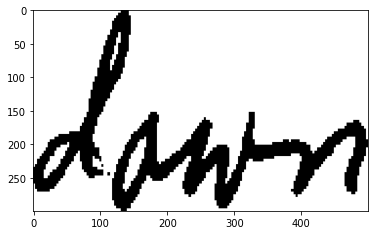

In [ ]:
# Testing the Ensemble Architecture with authentic data
img_1 = image.load_img('/content/drive/MyDrive/Forgery-identification/Dataset/testing-set/Authentic/b11_9.png',target_size=(300,500))
plt.imshow(img_1)
arr_1 = image.img_to_array(img_1)
arr_1 = np.expand_dims(arr_1, axis=0)
img_data_1 = mobilenet.preprocess_input(arr_1)

class_index1 = ensemble_predictions(models, img_data_1)[0]
label1 = pred_class(class_index1)
print('The shown image date is', label1)

The shown image date is Forged


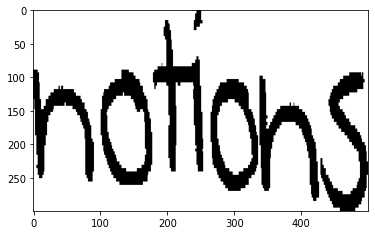

In [ ]:
# Testing the Ensemble Architecture with forged data
img_2 = image.load_img('/content/drive/MyDrive/Forgery-identification/Dataset/testing-set/Forged/b12_10.png',target_size=(300,500))
plt.imshow(img_2)
arr_2 = image.img_to_array(img_2)
arr_2 = np.expand_dims(arr_2, axis=0)
img_data_2 = mobilenet.preprocess_input(arr_2)

class_index2 = ensemble_predictions(models, img_data_2)[0]
label2 = pred_class(class_index2)
print('The shown image date is', label2)

##Visualization


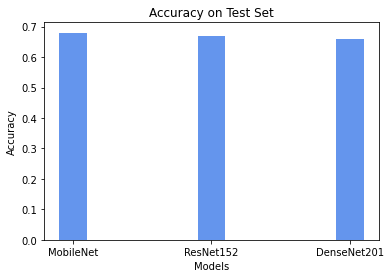

In [ ]:
plt.bar('MobileNet', accuracy1, color = 'cornflowerblue', width = 0.2, align = 'center')
plt.bar('ResNet152', accuracy2, color = 'cornflowerblue', width = 0.2, align = 'center')
plt.bar('DenseNet201', accuracy3, color = 'cornflowerblue', width = 0.2, align = 'center')
plt.title('Accuracy on Test Set')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.show()

In [ ]:
mobile_dict = mobile_fit.history
mobile_dict.keys()
acc1 = mobile_dict['accuracy']
ls1 = mobile_dict['loss']
epochs = range(1, len(acc1) + 1)

In [ ]:
resnet_dict = resnet_fit.history
resnet_dict.keys()
acc2 = resnet_dict['accuracy']
ls2 = resnet_dict['loss']
epochs = range(1, len(acc2) + 1)

In [ ]:
Dense_dict = Dense_fit.history
Dense_dict.keys()
acc3 = Dense_dict['accuracy']
ls3 = Dense_dict['loss']
epochs = range(1, len(acc3) + 1)

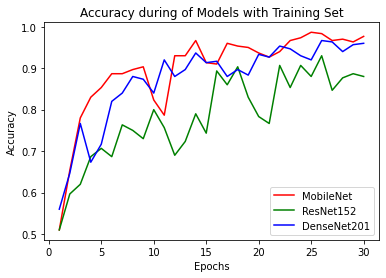

In [ ]:
plt.plot(epochs, acc1, 'r', label='MobileNet')
plt.plot(epochs, acc2, 'g', label='ResNet152')
plt.plot(epochs, acc3, 'b', label='DenseNet201')
plt.title('Accuracy during of Models with Training Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

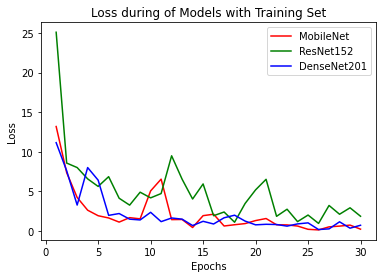

In [ ]:
plt.plot(epochs, ls1, 'r', label='MobileNet')
plt.plot(epochs, ls2, 'g', label='ResNet152')
plt.plot(epochs, ls3, 'b', label='DenseNet201')
plt.title('Loss during of Models with Training Set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##To Print the .ipynb file as a pdf


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('forgery-identification.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Minor_Project_Code.ipynb to pdf
[NbConvertApp] Support files will be in Minor_Project_Code_files/
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Making directory ./Minor_Project_Code_files
[NbConvertApp] Writing 228517 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'